In [14]:
from PIL import Image, ImageDraw
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
locations = ['SLC', 'SFO','HNL', 'ANC']
filenames = ["../data/Weather_" + location + "_2023.csv" for location in locations]

# List to store DataFrames
df_list = []

# Read each CSV file into a DataFrame and append to the list
for filename in filenames:
    df = pd.read_csv(filename, delimiter=',')
    keep = ['DATE', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'HourlyWindSpeed','HourlyWindDirection', 'HourlyPrecipitation']
    df = df[keep]
    df.ffill(inplace=True)
    df['timestamp']=pd.to_datetime(df['DATE'], format='%Y-%m-%dT%H:%M:%S')
    df.set_index(df['timestamp'], inplace=True)
    df.drop(columns=['DATE'], inplace=True)
    # Drop the 'STATION' column
    df.drop(columns=['timestamp'], inplace=True)
    # Convert object columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    # Replace NaN values with 0.0
    df.fillna(0.0, inplace=True)
    df = df.resample('60min').max()
    start = pd.to_datetime('2022-12-21 22:00')
    end = pd.to_datetime('2023-12-21 21:00')
    df = df.loc[(df.index >= start) & (df.index <= end)]
    df_list.append(df)

#columns_to_extract = ['HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyVisibility']
columns_to_extract = [ 'HourlyPrecipitation', 'HourlyWindSpeed']
# List to store new DataFrames for each channel
df_channel = []

# Process each channel
for column in columns_to_extract:
    # Create a new DataFrame for the current column
    channel_df = pd.DataFrame()
    
    # Extract and rename the column from each DataFrame in df_list
    for i, location in enumerate(locations):
        column_name = f"{column}_{location}"
        channel_df[column_name] = df_list[i][column]
    
    # Append the new DataFrame to the list
    df_channel.append(channel_df)

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_85018/2471302914.py:9: DtypeWarning: Columns (44,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter=',')
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_85018/2471302914.py:9: DtypeWarning: Columns (21,27,28,29,30,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter=',')
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_85018/2471302914.py:9: DtypeWarning: Columns (49,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter=',')
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_85018/2471302914.py:9: DtypeWarning: Columns (21,27,28,29,31,32,33,35,42,44,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter=',')


In [16]:
# Display one resulting DataFrames
df_channel[1].head()

,HourlyWindSpeed_SLC,HourlyWindSpeed_SFO,HourlyWindSpeed_HNL,HourlyWindSpeed_ANC
timestamp,,,,
2022-12-21 22:00:00,9.0,7.0,0.0,9.0
2022-12-21 23:00:00,9.0,0.0,0.0,8.0
2022-12-22 00:00:00,11.0,0.0,0.0,9.0
2022-12-22 01:00:00,17.0,7.0,0.0,7.0
2022-12-22 02:00:00,17.0,0.0,0.0,8.0


In [17]:
#smooth data for animation purposes
def custom_smooth(series, window_size=10):
    # Calculate the moving average with a centered window
    smooth_series = series.rolling(window=window_size, center=True).mean()
    
    # Fill the NaN values at the edges with original values
    smooth_series[:window_size//2] = series[:window_size//2]
    smooth_series[-window_size//2:] = series[-window_size//2:]
    
    return smooth_series

smoothed_dfs = [df.apply(custom_smooth) for df in df_channel]

In [18]:
# Normalize each resampled DataFrame independently
normalized_df_list = []
for channel_df in smoothed_dfs:
    channel_df.fillna(0, inplace=True)
    normalized_df = channel_df.copy()
    min_val = channel_df.min().min()
    max_val = channel_df.max().max()
    normalized_df = (((channel_df - min_val) / (max_val - min_val)) * 255).fillna(0).astype(int)
    normalized_df_list.append(normalized_df)

normalized_df_list[1].head(20)

,HourlyWindSpeed_SLC,HourlyWindSpeed_SFO,HourlyWindSpeed_HNL,HourlyWindSpeed_ANC
timestamp,,,,
2022-12-21 22:00:00,57,44,0,57
2022-12-21 23:00:00,57,0,0,50
2022-12-22 00:00:00,69,0,0,57
2022-12-22 01:00:00,108,44,0,44
2022-12-22 02:00:00,108,0,0,50
2022-12-22 03:00:00,77,26,3,52
2022-12-22 04:00:00,77,26,5,53
2022-12-22 05:00:00,78,29,8,54
2022-12-22 06:00:00,78,33,12,57


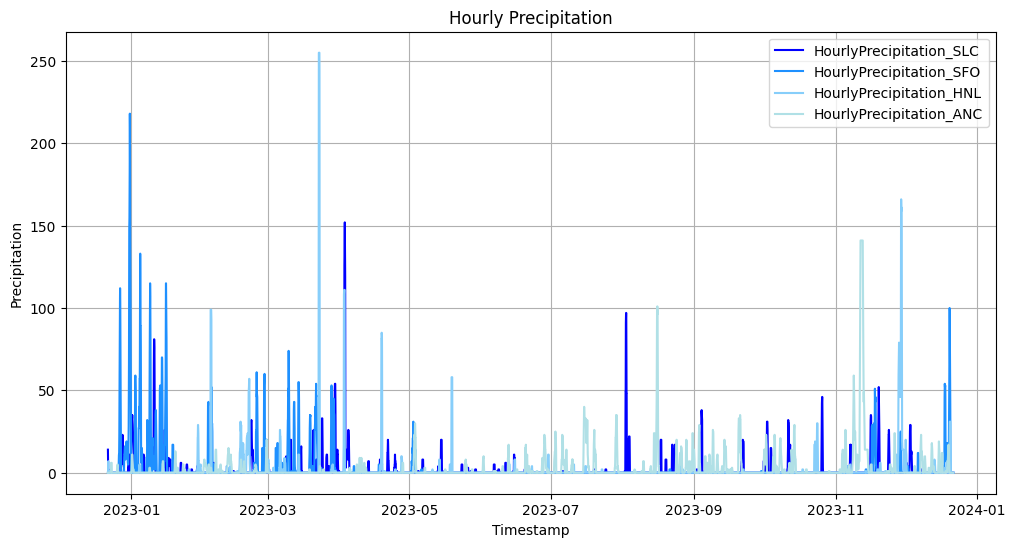

In [20]:
df = normalized_df_list[0]

# Plotting
plt.figure(figsize=(12, 6))

# Colors in different shades of blue
colors = ['#0000FF', '#1E90FF', '#87CEFA', '#B0E0E6']

# Plot each column with different shade of blue
for i, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[i])

plt.title('Hourly Precipitation')
plt.xlabel('Timestamp')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
def map_hat(y, height):
    # Normalize y to the range 0 to 1
    t = y / height
    # Apply a sinusoidal function to map y to the desired range
    mapped_value = 255 * np.sin(np.pi * t)
    return mapped_value

def hermite_interpolate(p0, p1, m0, m1, t):
    t2 = t * t
    t3 = t2 * t
    h00 = 2*t3 - 3*t2 + 1
    h10 = t3 - 2*t2 + t
    h01 = -2*t3 + 3*t2
    h11 = t3 - t2
    return h00 * p0 + h10 * m0 + h01 * p1 + h11 * m1

def create_hermite_gradient_image(width, height, gradient_start_value, gradient_mid_value, gradient_end_value, gradient_start_point, gradient_mid_point, gradient_end_point):
    # Create an image with a black background
    image = Image.new('L', (width, height), 'black')
    pixels = image.load()

    for y in range(1, height):  # Start the range from 1
        if y < gradient_start_point:
            value = gradient_start_value
        elif y <= gradient_mid_point:
            # Hermite parameters for the first half
            t = (y - gradient_start_point) / (gradient_mid_point - gradient_start_point)
            value = hermite_interpolate(gradient_start_value, gradient_mid_value, 0, 0, t)
        elif y <= gradient_end_point:
            # Hermite parameters for the second half
            t = (y - gradient_mid_point) / (gradient_end_point - gradient_mid_point)
            value = hermite_interpolate(gradient_mid_value, gradient_end_value, 0, 0, t)
        else:
            value = gradient_end_value
        
        # Ensure value is within the valid range
        value = max(0, min(255, int(value)))
        
        for x in range(width):
            pixels[x, y] = value
    
    return image

In [22]:
# Example usage
width, height = 232, 280
#values
gradient_start_value = 0  # Starting grayscale value
gradient_mid_value = 255  # Mid-point grayscale value
gradient_end_value = 0  # Ending grayscale value
#locations
gradient_start_point = 0  # Starting y-coordinate
gradient_mid_point = height/2  # Mid-point y-coordinate (for example, halfway of current end point)
gradient_end_point = height  # Ending y-coordinate


for normalized_df in normalized_df_list:
    for column in normalized_df.columns:

        # Extract the location and channel from the column name
        channel, location = column.rsplit('_', 1)

        # Create directories if they do not exist
        directory_path = f'../img/{location}/{channel}'
        os.makedirs(directory_path, exist_ok=True)

        for i, value in enumerate(normalized_df[column].values):
            gradient_mid_value = value  # Mid-point grayscale value
            
            # Create the gradient image
            image = create_hermite_gradient_image(width, height, gradient_start_value, gradient_mid_value, gradient_end_value, gradient_start_point, gradient_mid_point, gradient_end_point)
            
            # Save the image
            image_filename = f'{directory_path}/{location}_{channel}_flare_{i}.png'
            image.save(image_filename)
            
            # Optionally, display the image
            #image.show()
            
            #print(f'Saved img to {image_filename}')
